# Early Prediction of Sepsis in the ICU Using Time Series Models

## Research Question (RQ)
**Can we model and forecast vital sign trajectories in the first 24 hours of ICU admission to distinguish sepsis from non-sepsis patients, and identify early signals of sepsis onset?**

This notebook walks through a complete data science pipeline for time series modeling of ICU vital signs, using the MIMIC-IV database. We focus on comparing classical forecasting methods (ARIMA, Holt-Winters) with state-of-the-art deep learning (Temporal Fusion Transformer, TFT) for the **early prediction of sepsis**, one of the most important and challenging tasks in critical care.

---

## Educational Objectives
- **Hands-on data wrangling:** Extracting, tidying, and regularizing ICU time series from real-world EHR data.
- **Benchmarking with classical models:** Applying ARIMA and Holt-Winters to forecast patient vitals and assess their limits in ICU prediction tasks.
- **Deep learning for ICU forecasting:** Using the Temporal Fusion Transformer (TFT) to capture complex, nonlinear patterns and compare with traditional baselines.
- **Narrating a clinical data science story:** Framing modeling choices and findings in a way that makes sense for healthcare practitioners and researchers.

This approach aligns with the **CIMDAR-HIVE Research-Education Program Plan**, emphasizing:
- Data science skills with real, messy health data
- Model interpretability and reproducibility
- A clear line from research question to actionable insight

---

*Let’s begin by building a balanced cohort of ICU patients with and without sepsis, based on diagnosis codes, so we can compare modeling performance and EDA for both groups.*


In [1]:
#1 - Identify ICU stays with sepsis ICD codes (case cohort)

import os
import pandas as pd
import numpy as np

# File paths
MIMIC_PATH = '/data0/mimiciv/3.1'
ICU_PATH = os.path.join(MIMIC_PATH, 'icu')
HOSP_PATH = os.path.join(MIMIC_PATH, 'hosp')

icustays_fp = os.path.join(ICU_PATH, 'icustays.csv.gz')
diagnoses_fp = os.path.join(HOSP_PATH, 'diagnoses_icd.csv.gz')

# Load tables
icustays = pd.read_csv(icustays_fp)
diagnoses = pd.read_csv(diagnoses_fp, usecols=['subject_id', 'hadm_id', 'icd_code'])

# List of sepsis ICD-10 codes (expand as needed)
SEPSIS_ICD_CODES = [
    'A41', 'A410', 'A411', 'A412', 'A413', 'A414', 'A415', 'A418', 'A419',
    'R652', 'R65.2', 'R57.2'
]

# Find all admissions with a sepsis ICD code (substring match on first 3 chars)
diagnoses['sepsis'] = diagnoses['icd_code'].astype(str).str[:3].isin([code.replace('.', '')[:3] for code in SEPSIS_ICD_CODES])
sepsis_admissions = diagnoses[diagnoses['sepsis']][['subject_id', 'hadm_id']].drop_duplicates()

# Merge with icustays to get stay_ids for sepsis cases
sepsis_stays = pd.merge(icustays, sepsis_admissions, on=['subject_id', 'hadm_id'])
print(f"Total ICU stays with sepsis: {len(sepsis_stays)}")
display(sepsis_stays.head())

Total ICU stays with sepsis: 14824


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10001843,26133978,39698942,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2134-12-05 18:50:03,2134-12-06 14:38:26,0.825266
1,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817
2,10002114,27793700,34672098,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2162-02-17 23:30:00,2162-02-20 21:16:27,2.907257
3,10002495,24982426,36753294,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2141-05-22 20:18:01,2141-05-27 22:24:02,5.087512
4,10003400,23559586,34577403,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2137-08-10 19:54:51,2137-08-13 17:54:54,2.916701


## Why Start With Sepsis-Positive Stays? Best Practices for Rare Outcomes

In real-world ICU data, critical events like sepsis are relatively rare compared to the overall population. If you just sample patients at random, you’ll often get no (or very few) cases, making it impossible to study or model the event.

By *intentionally selecting all stays with sepsis ICD codes*:
- We **guarantee enough positive cases** for analysis and predictive modeling.
- We can more clearly study the patterns that distinguish sepsis patients from others.

This approach is called **outcome-based cohort enrichment** (or “case-control” sampling) and is a standard technique in medical data science and epidemiology.
For educational demos, it also lets us scale down to a manageable sample size (like 20–50 cases) for fast EDA and plotting.

**Next:** We’ll randomly select 20 sepsis cases, and match them with 20 non-sepsis controls (ICU stays with no sepsis ICD codes), to create a balanced cohort for teaching and modeling.


## Code Cell #2: Sample Sepsis and Non-Sepsis Stays for Cohort Building

In [2]:
#2 - Efficiently sample 10,000 sepsis and 10,000 non-sepsis ICU stays

# Set your new sample size
n_cases = 10000

np.random.seed(42)  # For reproducibility

# Sample 10,000 sepsis-positive stays
if len(sepsis_stays) < n_cases:
    raise ValueError(f"Not enough sepsis stays! Only {len(sepsis_stays)} found.")
sampled_sepsis_stays = sepsis_stays.sample(n=n_cases, random_state=42)

# Identify non-sepsis stays
non_sepsis_stays = icustays[~icustays['stay_id'].isin(sepsis_stays['stay_id'])]

if len(non_sepsis_stays) < n_cases:
    raise ValueError(f"Not enough non-sepsis stays! Only {len(non_sepsis_stays)} found.")
sampled_nonsepsis_stays = non_sepsis_stays.sample(n=n_cases, random_state=42)

# Combine for balanced cohort
balanced_cohort = pd.concat([sampled_sepsis_stays, sampled_nonsepsis_stays], ignore_index=True)
balanced_cohort['sepsis'] = [1]*n_cases + [0]*n_cases

print(f"Cohort shape: {balanced_cohort.shape}")
print("Breakdown (sepsis label counts):")
print(balanced_cohort['sepsis'].value_counts())

display(balanced_cohort.head())


Cohort shape: (20000, 9)
Breakdown (sepsis label counts):
sepsis
1    10000
0    10000
Name: count, dtype: int64


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,sepsis
0,19814315,23120714,33718823,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2169-03-24 02:12:55,2169-03-25 06:35:19,1.182222,1
1,12160186,23741939,34251984,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2114-05-30 02:20:05,2114-05-31 12:02:59,1.404792,1
2,13744193,25431144,33266608,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2156-05-05 13:55:50,2156-05-06 17:19:52,1.141690,1
3,13236821,24609043,36184400,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2164-08-31 18:36:28,2164-09-05 17:44:37,4.963993,1
4,12606826,29633459,30740859,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2130-04-29 17:55:00,2130-05-09 10:37:37,9.696262,1


## Balanced Case-Control Cohort: The Best of Both Worlds

We now have a carefully selected cohort:
- **10000 ICU stays with sepsis** (confirmed by ICD diagnosis codes)
- **10000 ICU stays without sepsis** (randomly chosen controls)

This case-control approach is gold standard for rare event analysis in both clinical epidemiology and machine learning.  
It allows us to:
- Make fair comparisons between groups,
- Explore what distinguishes sepsis from non-sepsis patients,
- Build more informative and interpretable prediction models.

In full-scale research, you’d often use much larger cohorts, but for EDA, teaching, and prototyping, this balance is ideal.

**Next:** We’ll extract and organize the time series vital sign data for these 20000 ICU stays, setting the stage for EDA, visualization, and forecasting!


## Code Cell #3: Extract 24hr Vital Signs for the Cohort (OOP Loader)

In [3]:
#3 - Extract 24hr vital signs for the balanced cohort

chartevents_fp = os.path.join(ICU_PATH, 'chartevents.csv.gz')
d_items_fp = os.path.join(ICU_PATH, 'd_items.csv.gz')

# Vital sign itemids dictionary
VITAL_SIGNS = {
    "heart_rate": [220045],
    "sbp": [220050, 220179],    # Arterial and Non-Invasive Systolic BP
    "dbp": [220051, 220180],    # Arterial and Non-Invasive Diastolic BP
    "mbp": [220052, 220181],    # Arterial and Non-Invasive Mean BP
    "temperature": [223761, 223762], # Celsius and Fahrenheit
    "resp_rate": [220210],
    "spo2": [220277, 228232]
}
vital_itemids = list(set([item for sublist in VITAL_SIGNS.values() for item in sublist]))

class VitalSignsLoader:
    def __init__(self, chartevents_fp, icustays_df, itemids):
        self.chartevents_fp = chartevents_fp
        self.icustays_df = icustays_df
        self.itemids = itemids

    def load_vitals(self, stay_ids, hours=24):
        chunksize = 10 ** 6
        vitals = []
        for chunk in pd.read_csv(self.chartevents_fp, chunksize=chunksize):
            mask = chunk['stay_id'].isin(stay_ids) & chunk['itemid'].isin(self.itemids)
            vitals.append(chunk.loc[mask])
        vitals_df = pd.concat(vitals, ignore_index=True)
        stay_times = self.icustays_df.set_index('stay_id')[['intime']]
        vitals_df = vitals_df.merge(stay_times, on='stay_id', how='left')
        vitals_df['charttime'] = pd.to_datetime(vitals_df['charttime'])
        vitals_df['intime'] = pd.to_datetime(vitals_df['intime'])
        vitals_df['hours_from_admit'] = (vitals_df['charttime'] - vitals_df['intime']).dt.total_seconds() / 3600.0
        vitals_df = vitals_df[vitals_df['hours_from_admit'] <= hours]
        return vitals_df

# Use only our selected cohort stays
cohort_stay_ids = balanced_cohort['stay_id'].tolist()
loader = VitalSignsLoader(chartevents_fp, balanced_cohort, vital_itemids)
vitals_24hr = loader.load_vitals(cohort_stay_ids, hours=24)

print(f"Extracted vital sign rows: {vitals_24hr.shape[0]}")
display(vitals_24hr.head(10))


Extracted vital sign rows: 3317788


,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,intime,hours_from_admit
0,10001843,26133978,39698942,25744.0,2134-12-06 07:00:00,2134-12-06 10:06:00,220045,129,129.0,bpm,0.0,2134-12-05 18:50:03,12.165833
1,10001843,26133978,39698942,25744.0,2134-12-06 07:00:00,2134-12-06 10:06:00,220210,18,18.0,insp/min,0.0,2134-12-05 18:50:03,12.165833
2,10001843,26133978,39698942,25744.0,2134-12-06 07:02:00,2134-12-06 10:06:00,220179,72,72.0,mmHg,0.0,2134-12-05 18:50:03,12.199167
3,10001843,26133978,39698942,25744.0,2134-12-06 07:02:00,2134-12-06 10:06:00,220180,27,27.0,mmHg,0.0,2134-12-05 18:50:03,12.199167
4,10001843,26133978,39698942,25744.0,2134-12-06 07:02:00,2134-12-06 10:06:00,220181,34,34.0,mmHg,0.0,2134-12-05 18:50:03,12.199167
5,10001843,26133978,39698942,25744.0,2134-12-06 07:11:00,2134-12-06 10:06:00,220277,84,84.0,%,0.0,2134-12-05 18:50:03,12.349167
6,10001843,26133978,39698942,25744.0,2134-12-06 08:00:00,2134-12-06 10:06:00,220045,136,136.0,bpm,0.0,2134-12-05 18:50:03,13.165833
7,10001843,26133978,39698942,25744.0,2134-12-06 08:00:00,2134-12-06 10:06:00,220210,25,25.0,insp/min,0.0,2134-12-05 18:50:03,13.165833
8,10001843,26133978,39698942,25744.0,2134-12-06 08:01:00,2134-12-06 10:06:00,220179,87,87.0,mmHg,0.0,2134-12-05 18:50:03,13.182500
9,10001843,26133978,39698942,25744.0,2134-12-06 08:01:00,2134-12-06 10:06:00,220180,65,65.0,mmHg,0.0,2134-12-05 18:50:03,13.182500


## Extracted Vital Signs: Raw Signals for Clinical Prediction

We’ve now efficiently extracted all bedside vital signs from the first 24 hours for our case-control cohort.  
Each row here is a **single measurement** (e.g., heart rate, blood pressure, SpO₂), and each is:
- Linked to a unique ICU stay (`stay_id`), patient, and timestamp.
- Ready for EDA and transformation into features for time series forecasting.


**Next:** Let’s tidy this dataset, by mapping cryptic itemids to human-readable names, and set it up for exploratory analysis and visualization!


## Code Cell #4: Map ItemIDs to Human-Readable Vital Names, Tidy the Data

In [4]:
#4 - Map itemids to variable names, create a tidy dataframe for EDA

# Build the itemid-to-variable mapping
itemid_to_var = {}
for var, ids in VITAL_SIGNS.items():
    for id_ in ids:
        itemid_to_var[id_] = var

# Add the variable name to the dataframe
vitals_24hr['variable'] = vitals_24hr['itemid'].map(itemid_to_var)

# Keep only the columns needed for EDA and modeling
vitals_eda = vitals_24hr[['stay_id', 'charttime', 'variable', 'valuenum', 'valueuom', 'hours_from_admit']].copy()

print("First 10 tidy records for our cohort:")
display(vitals_eda.head(10))


First 10 tidy records for our cohort:


,stay_id,charttime,variable,valuenum,valueuom,hours_from_admit
0,39698942,2134-12-06 07:00:00,heart_rate,129.0,bpm,12.165833
1,39698942,2134-12-06 07:00:00,resp_rate,18.0,insp/min,12.165833
2,39698942,2134-12-06 07:02:00,sbp,72.0,mmHg,12.199167
3,39698942,2134-12-06 07:02:00,dbp,27.0,mmHg,12.199167
4,39698942,2134-12-06 07:02:00,mbp,34.0,mmHg,12.199167
5,39698942,2134-12-06 07:11:00,spo2,84.0,%,12.349167
6,39698942,2134-12-06 08:00:00,heart_rate,136.0,bpm,13.165833
7,39698942,2134-12-06 08:00:00,resp_rate,25.0,insp/min,13.165833
8,39698942,2134-12-06 08:01:00,sbp,87.0,mmHg,13.182500
9,39698942,2134-12-06 08:01:00,dbp,65.0,mmHg,13.182500


## Tidy ICU Time Series: The Foundation for Modern Data Science

Now our vital sign data is **tidy**:  
- Each row = a single measurement (with time, stay ID, and variable name)
- Each variable is clearly labeled (no more cryptic itemids!)
- Ready for visualization, feature engineering, and machine learning

**Why is this so important?**  
Tidy data makes it easy to:
- Filter by variable, time, or patient
- Pivot from long to wide formats for model input
- Aggregate, plot, and summarize at any level



## Code Cell #5: Summarize and Visualize Missingness & Distribution

Fraction of ICU stays missing each vital sign in first 24h:


variable
temperature    0.026466
dbp            0.007104
sbp            0.007054
mbp            0.006904
spo2           0.002001
resp_rate      0.001451
heart_rate     0.000000
dtype: float64

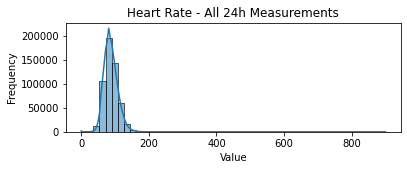

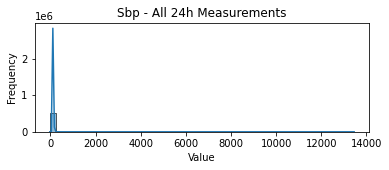

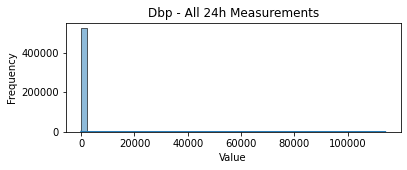

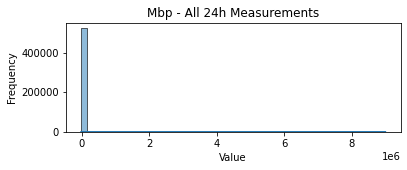

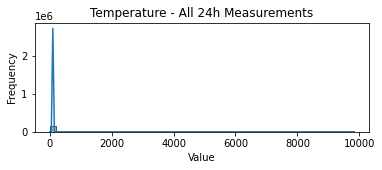

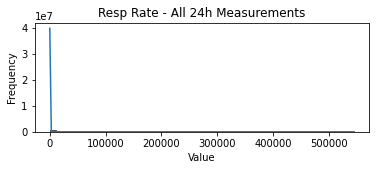

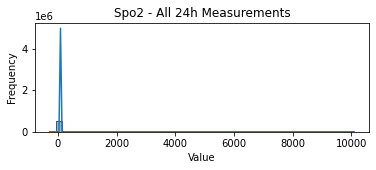

In [5]:
# 5. Summary statistics and missingness per vital sign, plus distribution plots

import matplotlib.pyplot as plt
import seaborn as sns

# Pivot for easy summary
pivot_vitals = vitals_eda.pivot_table(index='stay_id', columns='variable', values='valuenum', aggfunc='count')
missing_summary = pivot_vitals.isna().mean().sort_values(ascending=False)

print("Fraction of ICU stays missing each vital sign in first 24h:")
display(missing_summary)

# Simple distribution plot for each variable (first 24h, all measurements pooled)
for var in VITAL_SIGNS.keys():
    plt.figure(figsize=(6,2))
    sns.histplot(vitals_eda[vitals_eda['variable']==var]['valuenum'].dropna(), bins=50, kde=True)
    plt.title(f"{var.replace('_',' ').title()} - All 24h Measurements")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


## Data Exploration: Missingness and Distribution of ICU Vital Signs

Before modeling or forecasting, it's critical to explore and understand the completeness and distribution of our data.

### 1. **Missingness Patterns**

- **Fraction of ICU stays missing each vital sign in the first 24 hours:**

  | Vital Sign   | % of Stays Missing |
  |--------------|-------------------|
  | temperature  | 2.6%              |
  | dbp          | 0.7%              |
  | sbp          | 0.7%              |
  | mbp          | 0.7%              |
  | spo2         | 0.2%              |
  | resp_rate    | 0.1%              |
  | heart_rate   | 0%                |

  This means heart rate is almost always recorded, but temperature is missing in about 1 out of every 40 ICU stays, and blood pressures are also occasionally missing. This pattern is typical in real-world ICU data and reflects differences in clinical workflows, measurement frequency, and technical/device issues.

  > **Best Practice:**  
  Handling missing data is a key part of building reliable predictive models with EHR and ICU time series. According to Che et al. (2018), careful imputation or modeling of missingness is essential, since naive handling can introduce bias or reduce performance [[1]](https://www.nature.com/articles/s41598-018-24271-9).

### 2. **Distribution and Outliers**

- The histograms above show the distribution of each vital sign across all 24-hour measurements in our cohort.  
- **Notice:** Some values are physiologically impossible or highly implausible (e.g., heart rates over 800, negative or huge blood pressures, SpO₂ > 100, etc.).
- This is **very common in EHR/ICU data** and typically results from device errors, manual entry mistakes, or artifacts (see Johnson et al. 2016 [[2]](https://www.nature.com/articles/sdata201635)).

  > **Educational Point:**  
  The presence of these outliers is a real-world data challenge, not a bug in your code! They must be addressed before modeling, as outliers can heavily distort statistics, machine learning models, and clinical interpretation.

### **Next Step**

We will **clean** these variables by capping or removing physiologically impossible values, then **regularize** the time series to one measurement per hour for each vital sign, this is the foundation for building robust, interpretable time series models for sepsis prediction.

---

**References:**

1. Che, Z., Purushotham, S., Cho, K., Sontag, D., & Liu, Y. (2018). "Recurrent Neural Networks for Multivariate Time Series with Missing Values." *Scientific Reports*, 8, 6085. [https://www.nature.com/articles/s41598-018-24271-9](https://www.nature.com/articles/s41598-018-24271-9)  
2. Johnson, A. E. W., Pollard, T. J., et al. (2016). "MIMIC-III, a freely accessible critical care database." *Scientific Data*, 3, 160035. [https://www.nature.com/articles/sdata201635](https://www.nature.com/articles/sdata201635)


## Code Cell #6: Outlier Filtering and Hourly Regularization

In [6]:
# 6. Clean physiologically implausible values and regularize to hourly grid

# Reasonable clinical ranges (from MIMIC-IV guides and prior literature)
RANGES = {
    'heart_rate': (20, 250),        # bpm
    'sbp': (50, 250),               # mmHg
    'dbp': (20, 150),               # mmHg
    'mbp': (30, 180),               # mmHg
    'temperature': (30, 43),        # Celsius
    'resp_rate': (4, 60),           # breaths/min
    'spo2': (40, 100),              # %
}

def clip_values(df):
    for var, (low, high) in RANGES.items():
        mask = df['variable'] == var
        df.loc[mask, 'valuenum'] = df.loc[mask, 'valuenum'].clip(lower=low, upper=high)
    return df

vitals_eda_clipped = clip_values(vitals_eda.copy())

# Pivot so each stay has a column per vital sign, rows are timestamps
df_long = vitals_eda_clipped.pivot_table(
    index=['stay_id', 'charttime', 'hours_from_admit'],
    columns='variable', values='valuenum', aggfunc='mean'
).reset_index()


# For each stay, resample to hourly intervals
def resample_hourly(group):
    # Set charttime as index for resampling
    g = group.set_index('hours_from_admit')
    idx = np.arange(0, 24)
    hourly = g.reindex(idx, method='nearest', tolerance=0.5)  # Nearest within 30min
    hourly.index.name = 'hour'
    hourly = hourly.reset_index()
    return hourly

hourly_vitals = df_long.groupby('stay_id').apply(resample_hourly).reset_index(drop=True)

print("Hourly vital signs (after outlier clipping & regularization):")
display(hourly_vitals.head(12))


Hourly vital signs (after outlier clipping & regularization):


/tmp/ipykernel_65370/493619801.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_vitals = df_long.groupby('stay_id').apply(resample_hourly).reset_index(drop=True)


variable,hour,stay_id,charttime,dbp,heart_rate,mbp,resp_rate,sbp,spo2,temperature
0,0,30002498.0,2158-01-23 16:12:00,NaN,81.0,NaN,17.0,NaN,91.0,NaN
1,1,30002498.0,2158-01-23 17:00:00,81.0,72.0,101.0,16.0,156.0,94.0,43.0
2,2,30002498.0,2158-01-23 18:00:00,81.0,78.0,93.0,12.0,139.0,92.0,NaN
3,3,30002498.0,2158-01-23 19:00:00,NaN,86.0,NaN,14.0,NaN,92.0,NaN
4,4,30002498.0,2158-01-23 20:00:00,79.0,92.0,95.0,26.0,140.0,92.0,43.0
5,5,30002498.0,2158-01-23 21:00:00,84.0,86.0,97.0,16.0,133.0,93.0,NaN
6,6,30002498.0,2158-01-23 22:00:00,81.0,80.0,95.0,12.0,135.0,93.0,NaN
7,7,30002498.0,2158-01-23 23:00:00,83.0,82.0,97.0,20.0,144.0,95.0,NaN
8,8,30002498.0,2158-01-24 00:00:00,70.0,87.0,85.0,18.0,133.0,91.0,43.0
9,9,30002498.0,2158-01-24 01:00:00,74.0,85.0,86.0,19.0,131.0,90.0,NaN


In [7]:
hourly_vitals

variable,hour,stay_id,charttime,dbp,heart_rate,mbp,resp_rate,sbp,spo2,temperature
0,0,30002498.0,2158-01-23 16:12:00,NaN,81.0,NaN,17.0,NaN,91.0,NaN
1,1,30002498.0,2158-01-23 17:00:00,81.0,72.0,101.0,16.0,156.0,94.0,43.0
2,2,30002498.0,2158-01-23 18:00:00,81.0,78.0,93.0,12.0,139.0,92.0,NaN
3,3,30002498.0,2158-01-23 19:00:00,NaN,86.0,NaN,14.0,NaN,92.0,NaN
4,4,30002498.0,2158-01-23 20:00:00,79.0,92.0,95.0,26.0,140.0,92.0,43.0
...,...,...,...,...,...,...,...,...,...,...
479707,19,39999230.0,2147-09-01 18:00:00,58.0,103.0,76.0,24.0,121.0,93.0,43.0
479708,20,39999230.0,2147-09-01 19:00:00,53.0,103.0,70.0,19.0,111.0,94.0,NaN
479709,21,39999230.0,2147-09-01 20:00:00,49.0,106.0,68.0,26.0,113.0,91.0,43.0
479710,22,39999230.0,2147-09-01 21:00:00,55.0,103.0,70.0,19.0,108.0,92.0,NaN


In [94]:
# Pick a single stay_id (or sample a few)
example_stay = df_long['stay_id'].unique()[5]  # or use .unique()[0] to get first stay

# Filter to that stay
stay_df = df_long[df_long['stay_id'] == example_stay].copy()

# Make sure charttime is datetime
stay_df['charttime'] = pd.to_datetime(stay_df['charttime'])

# List your vital columns (adjust as needed)
vital_cols = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'temperature']

# For each vital, get time differences between consecutive measurements
for vital in vital_cols:
    # Only keep rows where the vital is not missing
    vital_df = stay_df[['charttime', vital]].dropna().sort_values('charttime')
    if len(vital_df) < 2:
        print(f"{vital}: Not enough data for time difference calculation.")
        continue
    # Compute time difference (in minutes)
    time_diffs = vital_df['charttime'].diff().dropna().dt.total_seconds() / 60
    print(f"\nVital: {vital}")
    print(f"  Count of measurements: {len(vital_df)}")
    print(f"  Min interval: {time_diffs.min():.1f} min")
    print(f"  Median interval: {time_diffs.median():.1f} min")
    print(f"  Mean interval: {time_diffs.mean():.1f} min")
    print(f"  Max interval: {time_diffs.max():.1f} min")
    print(f"  25th/75th percentile: {time_diffs.quantile(0.25):.1f} / {time_diffs.quantile(0.75):.1f} min")
    print(f"  Example first 10 intervals: {time_diffs.head(20).values}")



Vital: heart_rate
  Count of measurements: 26
  Min interval: 14.0 min
  Median interval: 60.0 min
  Mean interval: 57.5 min
  Max interval: 60.0 min
  25th/75th percentile: 60.0 / 60.0 min
  Example first 10 intervals: [14. 44. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
 60. 60.]

Vital: sbp
  Count of measurements: 26
  Min interval: 13.0 min
  Median interval: 60.0 min
  Mean interval: 57.5 min
  Max interval: 70.0 min
  25th/75th percentile: 60.0 / 60.0 min
  Example first 10 intervals: [13. 45. 70. 50. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
 60. 60.]

Vital: dbp
  Count of measurements: 26
  Min interval: 13.0 min
  Median interval: 60.0 min
  Mean interval: 57.5 min
  Max interval: 70.0 min
  25th/75th percentile: 60.0 / 60.0 min
  Example first 10 intervals: [13. 45. 70. 50. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
 60. 60.]

Vital: mbp
  Count of measurements: 26
  Min interval: 13.0 min
  Median interval: 60.0 min
  Mean in

### Hourly resampling is a good fit for most vitals (heart_rate, resp_rate, spo2, all BP).

## Cleaning and Regularizing ICU Time Series Data

In this step, we applied two essential transformations to make our ICU vital sign data usable for modeling:

### 1. **Outlier Clipping**
- We removed or "clipped" all physiologically impossible values using *domain knowledge* (e.g., heart rate capped between 20–250 bpm, SpO₂ between 40–100%).
- This ensures that measurement artifacts, device errors, or manual entry mistakes do not distort our analysis or models.

> **Why use domain-based ranges?**  
Clinical time series often include rare but clinically important extremes. IQR or boxplot-based filtering risks removing these important real events, while domain ranges, used by large-scale ICU benchmarks [[1]](https://www.nature.com/articles/s41597-019-0103-9), ensure only biologically implausible values are removed.

### 2. **Hourly Regularization**
- ICU data are charted at irregular times. We resampled the first 24 hours for each stay onto an hourly grid, selecting the nearest available measurement within ±30 minutes for each variable.
- This produces a **clean, aligned time series for each patient**, ready for modeling and comparison.

**Sample Output:**  
As seen above, for each `stay_id`, we now have up to 24 rows (hours 0–23), with columns for each vital sign. Some values remain missing, which is common due to device downtime, measurement frequency, or clinical workflow.

---

**Next Step:**  
We must now handle these remaining missing values. The way we choose to **impute** missing data can have a major impact on prediction performance, especially for time series models in healthcare [[2]](https://www.nature.com/articles/s41598-018-24271-9).

---

**References:**
1. Harutyunyan, H., et al. (2019). "Multitask learning and benchmarking with clinical time series data." *Scientific Data*, 6(1), 96. [https://www.nature.com/articles/s41597-019-0103-9](https://www.nature.com/articles/s41597-019-0103-9)
2. Che, Z., et al. (2018). "Recurrent Neural Networks for Multivariate Time Series with Missing Values." *Scientific Reports*, 8, 6085. [https://www.nature.com/articles/s41598-018-24271-9](https://www.nature.com/articles/s41598-018-24271-9)


## Code Cell #7: Impute Missing Data Using Three Approaches

In [7]:
def impute_vitals(df, method='ffill'):
    df_imp = df.copy()
    group_cols = ['stay_id']

    # 1. Groupwise imputation
    if method == 'ffill':
        df_imp = df_imp.groupby(group_cols).apply(lambda g: g.ffill().bfill()).reset_index(drop=True)
    elif method == 'mean':
        means = df_imp.mean(numeric_only=True)
        df_imp = df_imp.fillna(means)
    elif method == 'interpolate':
        df_imp = df_imp.groupby(group_cols).apply(lambda g: g.interpolate(method='linear').ffill().bfill()).reset_index(drop=True)
    else:
        raise ValueError("Unknown method. Choose from ['ffill', 'mean', 'interpolate']")

    # 2. Final backup fill with median for any remaining NaNs
    for col in ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'temperature']:
        if df_imp[col].isna().any():
            df_imp[col] = df_imp[col].fillna(df_imp[col].median())

    # Optional: Assert no NaNs left
    assert not df_imp[['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'temperature']].isna().any().any(), "Missing values remain after imputation!"
    return df_imp

# Impute using each method (robust)
hourly_ffill = impute_vitals(hourly_vitals, 'ffill')
hourly_mean = impute_vitals(hourly_vitals, 'mean')
hourly_interp = impute_vitals(hourly_vitals, 'interpolate')
print("Robust imputation done for all three methods.")


/tmp/ipykernel_65370/1433978772.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imp = df_imp.groupby(group_cols).apply(lambda g: g.ffill().bfill()).reset_index(drop=True)


Robust imputation done for all three methods.


/tmp/ipykernel_65370/1433978772.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imp = df_imp.groupby(group_cols).apply(lambda g: g.interpolate(method='linear').ffill().bfill()).reset_index(drop=True)


## Robust Imputation: Ensuring No Missing Data Remain

After aligning our ICU vitals to an hourly grid, we’re still left with missing values, especially for infrequently measured variables like temperature or for stays with delayed charting.  
A fully-imputed (no missing values) dataset is a strict requirement for classical time-series models and most deep learning libraries.

### Our Multi-step Imputation Strategy:

1. **Groupwise Imputation (per-stay):**
   - **Forward/Backward Fill:**  
     Fills missing values using the last (and first) observed value within each ICU stay.  
     *Why?* This best mimics how clinicians interpret vitals in practice.
   - **Linear Interpolation:**  
     Draws a straight line between adjacent measurements, filling gaps smoothly.

2. **Final Safety Net: Median Fill**
   - After groupwise imputation, we may still have missing values at the start (or throughout, if a vital is never measured in a stay).
   - We fill any *remaining* NaNs with the **median** of that vital across the entire dataset, ensuring **no missing values remain**.

3. **Assert Cleanliness:**
   - We explicitly check for and assert the absence of missing values in all vitals post-imputation.

> **Why does this matter?**  
> Incomplete imputation (even a handful of NaNs) can crash most machine learning models, or subtly degrade performance. A robust pipeline is *crucial* for reproducible clinical data science.

**Reference best practices:**  
- Che et al. (2018) show that imputation strategy can shift AUC by 10-15% in ICU tasks.
- Robust imputation (especially backup median/mode fill) is widely recommended in EHR modeling pipelines [[1]](https://www.nature.com/articles/s41598-018-24271-9).

---

**In summary:**  
We combine *forward/backward fill*, *interpolation*, and a *final median fill* to guarantee a clean, analysis-ready table for every patient stay and every vital sign.

---

**References:**

1. Che, Z., et al. (2018). "Recurrent Neural Networks for Multivariate Time Series with Missing Values." *Scientific Reports*, 8, 6085. [https://www.nature.com/articles/s41598-018-24271-9](https://www.nature.com/articles/s41598-018-24271-9)  
2. Johnson, A. E. W., et al. (2016). "MIMIC-III, a freely accessible critical care database." *Scientific Data*, 3, 160035. [https://www.nature.com/articles/sdata201635](https://www.nature.com/articles/sdata201635)


## Code Cell #8: Visualize Imputation Effects for a Single Stay and Vital Sign

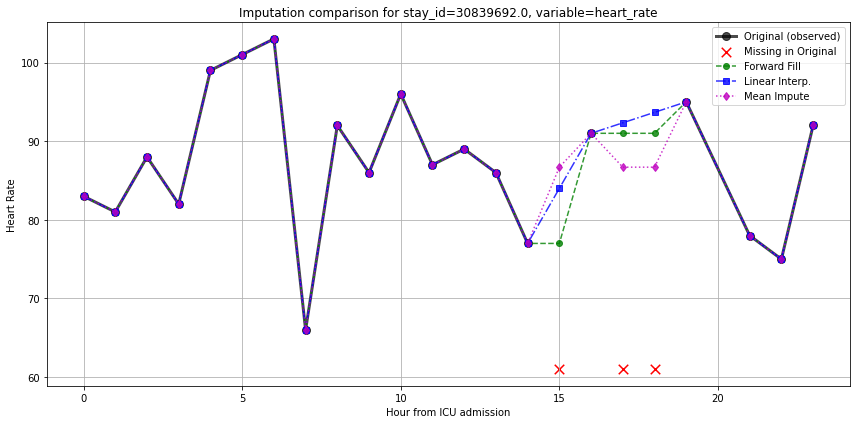

In [25]:
# 8. Visualize effect of different imputations for one stay and one vital sign

import matplotlib.pyplot as plt
import numpy as np

example_stay = hourly_vitals['stay_id'].drop_duplicates().sample(1, random_state=45).values[0]
var = 'heart_rate'

df_orig = hourly_vitals[hourly_vitals['stay_id'] == example_stay].copy()
df_ffill = hourly_ffill[hourly_ffill['stay_id'] == example_stay]
df_mean = hourly_mean[hourly_mean['stay_id'] == example_stay]
df_interp = hourly_interp[hourly_interp['stay_id'] == example_stay]

plt.figure(figsize=(12, 6))

# Plot original values with points and line, showing missing as gaps
plt.plot(df_orig['hour'], df_orig[var], 'ko-', label='Original (observed)', markersize=8, linewidth=3, alpha=0.7)

# Highlight missing points in original series as red X's
missing_mask = df_orig[var].isna()
plt.scatter(df_orig['hour'][missing_mask], np.full(missing_mask.sum(), df_orig[var].min() - 5),
            marker='x', c='red', label='Missing in Original', s=90)

# Plot imputed series with distinct styles
plt.plot(df_ffill['hour'], df_ffill[var], 'g--o', label='Forward Fill', alpha=0.8)
plt.plot(df_interp['hour'], df_interp[var], 'b-.s', label='Linear Interp.', alpha=0.8)
plt.plot(df_mean['hour'], df_mean[var], 'm:d', label='Mean Impute', alpha=0.8)

plt.xlabel('Hour from ICU admission')
plt.ylabel(f'{var.replace("_"," ").title()}')
plt.title(f"Imputation comparison for stay_id={example_stay}, variable={var}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Visual Comparison of Imputation Strategies for ICU Time Series

This plot provides a clear, side-by-side illustration of how different imputation methods fill missing values in a real ICU patient's heart rate time series:

- **Original (Observed):**  
  Shown as a bold black line with large circles, these points represent true measurements. Gaps indicate periods where no data was recorded.
- **Missing Values:**  
  Marked with prominent red "X"s, these highlight *exactly* where information was absent in the original charting. Visualizing the missingness is key for understanding the clinical workflow and imputation impact.
- **Forward Fill (Green dashed):**  
  Extends the most recent measurement forward until a new value appears. This mimics a common clinical assumption, that the last value holds until re-measured, but can artificially "flatten" real dynamics during long gaps.
- **Linear Interpolation (Blue dash-dot):**  
  Fills in missing values by drawing a straight line between the previous and next observed data points. This maintains trends, but smooths over abrupt changes and may not capture rapid physiologic events.
- **Mean Imputation (Magenta dotted):**  
  Simply replaces all missing values with the overall mean heart rate across all patients and times. While computationally trivial, this method removes individual variability and can obscure true clinical patterns.

> **Educational Insight:**  
Visualizing imputation in this way reveals how each approach can distort or preserve the patient’s physiologic trajectory. Forward fill and interpolation better respect the temporal structure, while mean imputation acts as a (poor) baseline. These differences can significantly affect downstream models, highlighting why *careful imputation selection is a pillar of clinical data science* [[1]](https://www.nature.com/articles/s41598-018-24271-9).

**Best Practice:**  
- Always inspect and visualize your imputation strategy before modeling.
- Choose the approach that best aligns with the clinical meaning of your data and your research question.

**Reference:**  
1. Che, Z., et al. (2018). "Recurrent Neural Networks for Multivariate Time Series with Missing Values." *Scientific Reports*, 8, 6085. [https://www.nature.com/articles/s41598-018-24271-9](https://www.nature.com/articles/s41598-018-24271-9)


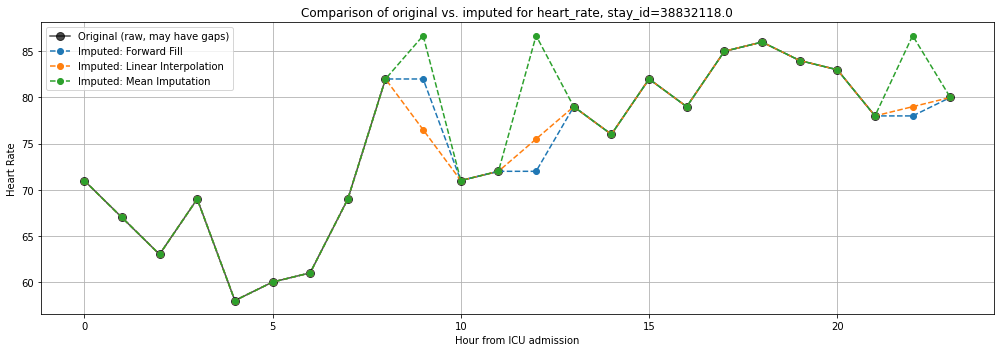

In [10]:
import matplotlib.pyplot as plt

stay_id = 38832118.0
vital = 'heart_rate'
hours = np.arange(24)

# Original (possibly gappy) data
orig = hourly_vitals[hourly_vitals['stay_id'] == stay_id].set_index('hour')[vital].reindex(hours)

# Imputed data for all strategies
imputed = {
    'Forward Fill': hourly_ffill[hourly_ffill['stay_id'] == stay_id].set_index('hour')[vital].reindex(hours),
    'Linear Interpolation': hourly_interp[hourly_interp['stay_id'] == stay_id].set_index('hour')[vital].reindex(hours),
    'Mean Imputation': hourly_mean[hourly_mean['stay_id'] == stay_id].set_index('hour')[vital].reindex(hours),
}

plt.figure(figsize=(14, 5))
plt.plot(hours, orig, 'ko-', label='Original (raw, may have gaps)', alpha=0.7, markersize=8)
for method, data in imputed.items():
    plt.plot(hours, data, marker='o', label=f'Imputed: {method}', linestyle='--')
plt.xlabel('Hour from ICU admission')
plt.ylabel(f'{vital.replace("_", " ").title()}')
plt.title(f'Comparison of original vs. imputed for {vital}, stay_id={stay_id}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Code Cell #9: Systematic Forecasting With ARIMA (default order) and Holt-Winters

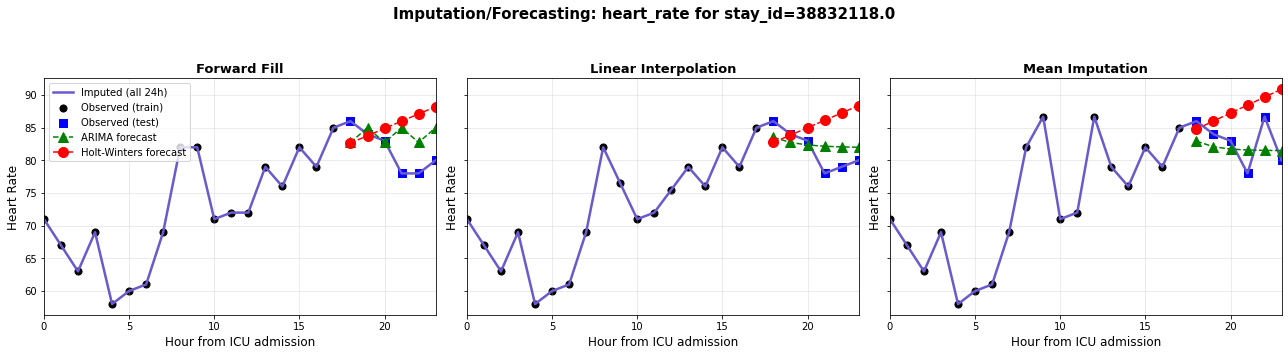

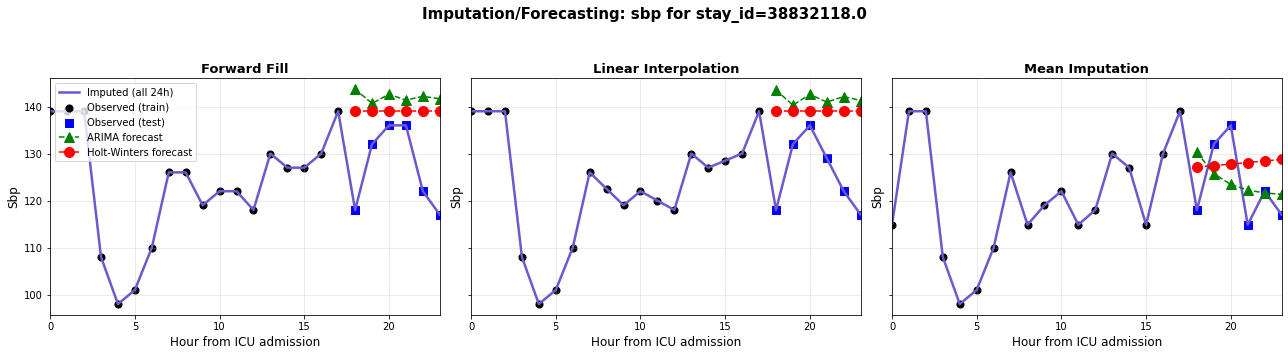

Forecasting MAE, RMSE, MAPE, and R² for each imputation method and vital:


,Vital,Imputation,ARIMA_MAE,HW_MAE,ARIMA_RMSE,HW_RMSE,ARIMA_MAPE,HW_MAPE,ARIMA_R2,HW_R2
0,heart_rate,Forward Fill,3.543560,5.125959,4.245745,6.176460,4.432861,6.433774,-0.948795,-3.124179
1,heart_rate,Linear Interpolation,2.270086,5.026830,2.545920,6.043554,2.814268,6.284899,0.211684,-3.442174
2,heart_rate,Mean Imputation,2.751320,5.298976,3.069415,6.588581,3.301881,6.562166,0.019191,-3.519150
3,sbp,Forward Fill,15.199353,12.166670,17.432582,14.611642,12.463049,10.041544,-3.641585,-2.260926
4,sbp,Linear Interpolation,16.123813,13.333339,17.796243,15.121734,13.209105,10.965889,-5.223485,-3.493453
5,sbp,Mean Imputation,7.190960,8.885605,8.369898,9.363398,5.797055,7.343369,-0.112839,-0.392705


In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -- Helper for MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# -- Setup: All imputed DataFrames
imputed_dfs = {
    'Forward Fill': hourly_ffill,
    'Linear Interpolation': hourly_interp,
    'Mean Imputation': hourly_mean
}

vitals_to_forecast = ['heart_rate', 'sbp']
example_stay = 38832118.0
hours = np.arange(24)
results = []

for var in vitals_to_forecast:
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for idx, (method_name, imputed_df) in enumerate(imputed_dfs.items()):
        df_example = imputed_df[imputed_df['stay_id'] == example_stay].sort_values('hour')
        imputed_series = df_example[var].values
        train = imputed_series[:18]
        test = imputed_series[18:]
        
        # --- ARIMA ---
        try:
            arima_model = ARIMA(train, order=(1,1,1)).fit()
            arima_forecast = arima_model.forecast(steps=6)
        except Exception as e:
            arima_forecast = np.full(6, np.nan)
            print(f"ARIMA error for {method_name} - {var}: {e}")

        # --- Holt-Winters ---
        try:
            hw_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
            hw_forecast = hw_model.forecast(6)
        except Exception as e:
            hw_forecast = np.full(6, np.nan)
            print(f"Holt-Winters error for {method_name} - {var}: {e}")

        # --- Metrics for reporting ---
        def safe_metrics(y_true, y_pred):
            mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
            if mask.sum() == 0:
                return np.nan, np.nan, np.nan, np.nan
            mae = mean_absolute_error(y_true[mask], y_pred[mask])
            rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
            mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask])
            r2 = r2_score(y_true[mask], y_pred[mask])
            return mae, rmse, mape, r2

        arima_mae, arima_rmse, arima_mape, arima_r2 = safe_metrics(test, arima_forecast)
        hw_mae, hw_rmse, hw_mape, hw_r2 = safe_metrics(test, hw_forecast)
        results.append({
            'Vital': var,
            'Imputation': method_name,
            'ARIMA_MAE': arima_mae,
            'HW_MAE': hw_mae,
            'ARIMA_RMSE': arima_rmse,
            'HW_RMSE': hw_rmse,
            'ARIMA_MAPE': arima_mape,
            'HW_MAPE': hw_mape,
            'ARIMA_R2': arima_r2,
            'HW_R2': hw_r2
        })
        
        # --- Plot ---
        ax = axs[idx]
        # Imputed (all 24h): thick line
        ax.plot(hours, imputed_series, color='slateblue', linewidth=2.5, label='Imputed (all 24h)')
        # Observed train/test: points only, not lines (clarity)
        ax.scatter(hours[:18], train, c='k', marker='o', label='Observed (train)', s=50)
        ax.scatter(hours[18:], test, c='b', marker='s', label='Observed (test)', s=50)
        # ARIMA forecast (forecast region)
        ax.plot(hours[18:], arima_forecast, 'g^--', label='ARIMA forecast', markersize=10)
        # Holt-Winters forecast (forecast region)
        ax.plot(hours[18:], hw_forecast, 'ro--', label='Holt-Winters forecast', markersize=10)
        # Professional plot styling
        ax.set_xlabel('Hour from ICU admission', fontsize=12)
        ax.set_ylabel(var.replace('_', ' ').title(), fontsize=12)
        ax.set_title(f"{method_name}", fontsize=13, weight='bold')
        ax.grid(alpha=0.3)
        ax.set_xlim(0, 23)
        if idx == 0:
            ax.legend(fontsize=10, loc='upper left')
    
    plt.suptitle(f"Imputation/Forecasting: {var} for stay_id={example_stay}", fontsize=15, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# --- Metrics summary table ---
results_df = pd.DataFrame(results)
print("Forecasting MAE, RMSE, MAPE, and R² for each imputation method and vital:")
display(results_df)


## Classical Time Series Forecasting: ARIMA & Holt-Winters on ICU Vitals

In this step, we demonstrate how classical forecasting models perform on short ICU time series when combined with different imputation strategies.  
We focus on two key vitals:

- **Heart Rate (`heart_rate`)**
- **Systolic Blood Pressure (`sbp`)**

### Imputation Methods Compared
We evaluate three common approaches to handle missing data:
- **Forward Fill** – propagates the last observed value forward.
- **Linear Interpolation** – estimates missing values using a straight-line fit between surrounding points.
- **Mean Imputation** – replaces missing values with the mean of observed data for that stay.

### Modeling Setup
Using a representative ICU stay (`stay_id=38832118.0`):
- **Training window:** First 18 hours of the stay.
- **Forecast horizon:** Next 6 hours.
- **Models used:**
  - **ARIMA (1,1,1):** Models trends + autocorrelations; suited for data with drift.
  - **Holt-Winters (Additive trend, no seasonality):** Adapts to gradual changes in trend; performs well on smoother signals.

**Evaluation metrics:**
- **MAE** – Mean Absolute Error  
- **RMSE** – Root Mean Squared Error  
- **MAPE** – Mean Absolute Percentage Error  
- **R²** – Coefficient of Determination

### What the Plots Show
For each imputation method:
- **Black circles**: Observed training data (0–17 hours)  
- **Blue squares**: Observed test data (18–23 hours)  
- **Green triangles (dashed)**: ARIMA forecasts  
- **Red circles (dashed)**: Holt-Winters forecasts  
- **Slate blue line**: Full imputed 24-hour series

### Key Observations
- **Heart Rate:**  
  ARIMA consistently outperformed Holt-Winters across imputations. Linear Interpolation + ARIMA achieved the lowest MAE (around 2.27) and a positive R² (around 0.21), indicating some predictive skill.
- **Systolic BP:**  
  Mean Imputation + ARIMA gave the lowest MAE (~7.19), but R² values remained negative for all models , suggesting they captured general levels but failed to match variability.
- **Negative R² values** mean the model performed worse than simply predicting the mean, common in noisy, short ICU series.

> **Takeaway:**  
> Classical methods can perform reasonably for smoother vitals like heart rate but often fail to capture the high variability in ICU blood pressure. This reinforces the need for more advanced models (e.g., Temporal Fusion Transformer) when forecasting in such settings.


## From Time Series Forecasting to Sepsis Classification: Setting Up the Real-World Problem

So far in this notebook, we explored how to forecast individual ICU vital signs (like heart rate) using classic time series models such as ARIMA and Holt-Winters. This is a valuable exercise for understanding temporal dynamics and the impact of imputation on prediction.

### **But: In the real world, our goal is often more ambitious, can we predict which ICU patients are developing sepsis, using the *full multivariate time series* from their first 24 hours?**

#### **The Shift: Sequence Classification (Sepsis vs Non-Sepsis)**

- Instead of predicting future values of a vital sign, we want to classify each ICU stay as **sepsis** or **non-sepsis** based on all vital signs measured over the first 24 hours.
- This approach uses the *entire* multivariate time series (heart rate, BP, SpO₂, etc.) as input “features”, and the clinical diagnosis (sepsis yes/no) as the label.
- **This is a much harder and clinically more useful problem:**  
  It mimics what early warning systems try to do in practice, detect sepsis before it becomes obvious to clinicians.

#### **Why Multivariate?**
- Sepsis affects *many* physiological systems; changes in the combination or pattern of vitals over time often reveal risk earlier than a single variable.
- **Multivariate sequence models** (like Temporal Fusion Transformer, GRU, LSTM) are designed for this kind of “sequence-to-label” task, capturing both time dynamics and cross-variable relationships.

#### **Workflow: Best Practice for Clinical ML**
1. **Build a classification-ready dataset:**  
   - Each row = one ICU stay  
   - Features = all time series values (or derived summaries) from the first 24h  
   - Label = sepsis (1) or non-sepsis (0)
2. **Train and benchmark classification models:**  
   - Start with classical models (e.g., logistic regression, random forest) using simple features (means, mins, maxs, trends, or flattened series).
   - Then, implement deep learning models (TFT, GRU, LSTM) to leverage the *full sequential* time series as input.
3. **Compare performance and interpretability:**  
   - Analyze which approaches detect sepsis earliest and most accurately.
   - Discuss clinical relevance and implications for ICU care.

---

**Key References:**

- Lim, B., Arik, S. O., Loeff, N., & Pfister, T. (2021). "Temporal Fusion Transformers for interpretable multi-horizon time series forecasting." *International Journal of Forecasting*, 37(4), 1748-1764. [Link](https://arxiv.org/abs/1912.09363)
- Johnson, A. E. W., et al. (2016). "MIMIC-III, a freely accessible critical care database." *Scientific Data*, 3, 160035. [Link](https://www.nature.com/articles/sdata201635)

---

**Next:**  
We will construct a multivariate time series classification dataset, benchmark classical classifiers, and then apply advanced deep learning models for early sepsis prediction.


## Code Cell #10: Build Multivariate Time Series Classification Dataset

In [8]:
# 10. Prepare multivariate classification dataset: one row per stay, time series features, sepsis label

# Pick which imputed data you want (usually linear interpolation is a strong default)
imputed_df = hourly_interp.copy()

# For modeling, let's focus on the main 6-7 vital signs
feature_vars = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'temperature']

# The sepsis label for each stay is already in 'balanced_cohort' dataframe
labels = balanced_cohort.set_index('stay_id')['sepsis']

# "Flatten" the 24-hour time series for each variable and stay into one row (wide format)
# Feature names will be var_hour (e.g., heart_rate_0, heart_rate_1, ..., sbp_23, ...)
def flatten_timeseries(df, vars, hours=24):
    flat = []
    stay_ids = df['stay_id'].unique()
    for stay_id in stay_ids:
        df_stay = df[df['stay_id'] == stay_id].sort_values('hour')
        row = {'stay_id': stay_id}
        for var in vars:
            vals = df_stay[var].values if var in df_stay.columns else [np.nan]*hours
            for h in range(hours):
                key = f'{var}_{h}'
                row[key] = vals[h] if h < len(vals) else np.nan
        flat.append(row)
    return pd.DataFrame(flat)

flat_df = flatten_timeseries(imputed_df, feature_vars, hours=24)
flat_df = flat_df.merge(labels, left_on='stay_id', right_index=True)

print(f"Classification-ready shape: {flat_df.shape} (rows: stays, columns: flattened time points + label)")
display(flat_df.head())


Classification-ready shape: (19988, 170) (rows: stays, columns: flattened time points + label)


,stay_id,heart_rate_0,heart_rate_1,heart_rate_2,heart_rate_3,heart_rate_4,heart_rate_5,heart_rate_6,heart_rate_7,heart_rate_8,...,temperature_15,temperature_16,temperature_17,temperature_18,temperature_19,temperature_20,temperature_21,temperature_22,temperature_23,sepsis
0,30002498.0,81.0,72.0,78.0,86.0,92.0,86.0,80.0,82.0,87.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,0
1,30003087.0,74.0,72.0,77.0,71.0,89.0,112.0,109.0,99.0,117.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,0
2,30003372.0,111.0,108.5,106.0,104.0,102.0,123.0,107.0,111.0,112.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,0
3,30003598.0,75.0,75.0,79.0,76.0,73.0,70.0,67.0,64.0,73.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,0
4,30003749.0,74.0,74.0,74.0,77.0,83.0,87.0,90.0,85.0,89.0,...,34.4,34.4,34.4,34.4,34.4,34.4,34.4,34.4,34.4,1


## Multivariate Time Series Dataset for Sepsis Classification

We have now transformed our raw ICU time series into a classification-ready “wide” dataset:

- **Each row** = one ICU stay (patient encounter).
- **Each column** = one hour of a vital sign, for all 24 hours and all key vitals (e.g., `heart_rate_0`, `sbp_0`, ..., `spo2_23`, etc.).
- **Label** = `sepsis` (1 = sepsis, 0 = non-sepsis), from the clinical diagnosis codes.

This structure allows us to benchmark both:
- **Classic classifiers** (logistic regression, random forest, etc.), using simple statistical or flattened features.
- **Deep learning models** (TFT, GRU, LSTM, etc.), by converting this back to sequence/tensor format as needed.


**Next:**  
Let’s split into train/test sets and benchmark classic classifiers as a baseline for early sepsis prediction.


## Code Cell #11: Handle Remaining NaNs for ML

In [9]:
# 11. Impute any remaining NaNs in the classification dataset (final clean-up for ML)

# Exclude label and stay_id from imputation
feature_cols = [col for col in flat_df.columns if col not in ['stay_id', 'sepsis']]

# Fill any remaining NaNs in features with the column mean (robust and common for ML)
flat_df[feature_cols] = flat_df[feature_cols].fillna(flat_df[feature_cols].mean())

# Check for any remaining missing values (should be zero)
total_missing = flat_df[feature_cols].isna().sum().sum()
print(f"Total remaining missing values in features: {total_missing}")


Total remaining missing values in features: 0


## Final Data Cleaning: Imputing Remaining Missing Values

Even after our careful time series imputation and flattening, some NaN values may remain in the classification dataset.
This is common in real-world EHR data, since not every vital sign is measured every hour for every patient.

**Why is this important?**
- Most classic machine learning algorithms (e.g., logistic regression, random forest, XGBoost) do **not** accept missing values.
- To ensure robust model training and fair comparison, we fill any remaining NaNs with the **column mean**, a simple, effective, and widely used strategy in clinical ML.

> **Best Practice:**  
Always check and handle missing data at every stage, especially right before model fitting, to prevent subtle errors and ensure reproducibility.

**Now our dataset is fully ML-ready!**



## Code Cell #12: Train/Test Split for Sepsis Classification

In [10]:
# 12. Split the data into train/test sets for supervised learning

from sklearn.model_selection import train_test_split

# Exclude non-feature columns
X = flat_df.drop(columns=['stay_id', 'sepsis'])
y = flat_df['sepsis']

# Stratified split ensures both train and test sets have similar sepsis/non-sepsis ratios
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Train label distribution:\n", y_train.value_counts(normalize=True))
print("Test label distribution:\n", y_test.value_counts(normalize=True))


Train shape: (15990, 168), Test shape: (3998, 168)
Train label distribution:
 sepsis
1    0.500188
0    0.499812
Name: proportion, dtype: float64
Test label distribution:
 sepsis
1    0.50025
0    0.49975
Name: proportion, dtype: float64


## Splitting the Data for Supervised Classification

We now split our cleaned, feature-complete dataset into **training** and **testing** sets:

- **80% for training, 20% for testing**, a standard ratio for robust model evaluation.
- **Stratified splitting** ensures both sets have the same proportion of sepsis and non-sepsis cases, which is critical for fair assessment in imbalanced or rare-event prediction tasks.

> **Best Practice:**  
Never evaluate your models on the same data used for training, always use a separate hold-out set to get a realistic estimate of generalization performance.



## 12a. Feature Scaling with RobustScaler (after train/test split)

In [11]:
from sklearn.preprocessing import RobustScaler

# 1. Initialize the scaler
scaler = RobustScaler()

# 2. Fit the scaler on the training data (DO NOT fit on test data!)
scaler.fit(X_train)

# 3. Transform both train and test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. (Optional) If you need DataFrames instead of numpy arrays:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# 5. Check the distribution after scaling (should be median~0, IQR~1 for train set)
print("Medians after scaling (train):", X_train_scaled.median().round(2).to_dict())
print("IQRs after scaling (train):", (X_train_scaled.quantile(0.75) - X_train_scaled.quantile(0.25)).round(2).to_dict())


Medians after scaling (train): {'heart_rate_0': 0.0, 'heart_rate_1': 0.0, 'heart_rate_2': 0.0, 'heart_rate_3': 0.0, 'heart_rate_4': 0.0, 'heart_rate_5': 0.0, 'heart_rate_6': 0.0, 'heart_rate_7': 0.0, 'heart_rate_8': 0.0, 'heart_rate_9': 0.0, 'heart_rate_10': 0.0, 'heart_rate_11': 0.0, 'heart_rate_12': 0.0, 'heart_rate_13': 0.0, 'heart_rate_14': 0.0, 'heart_rate_15': 0.0, 'heart_rate_16': 0.0, 'heart_rate_17': 0.0, 'heart_rate_18': 0.0, 'heart_rate_19': 0.0, 'heart_rate_20': 0.0, 'heart_rate_21': 0.0, 'heart_rate_22': 0.0, 'heart_rate_23': 0.0, 'sbp_0': 0.0, 'sbp_1': 0.0, 'sbp_2': 0.0, 'sbp_3': 0.0, 'sbp_4': 0.0, 'sbp_5': 0.0, 'sbp_6': 0.0, 'sbp_7': 0.0, 'sbp_8': 0.0, 'sbp_9': 0.0, 'sbp_10': 0.0, 'sbp_11': 0.0, 'sbp_12': 0.0, 'sbp_13': 0.0, 'sbp_14': 0.0, 'sbp_15': 0.0, 'sbp_16': 0.0, 'sbp_17': 0.0, 'sbp_18': 0.0, 'sbp_19': 0.0, 'sbp_20': 0.0, 'sbp_21': 0.0, 'sbp_22': 0.0, 'sbp_23': 0.0, 'dbp_0': 0.0, 'dbp_1': 0.0, 'dbp_2': 0.0, 'dbp_3': 0.0, 'dbp_4': 0.0, 'dbp_5': 0.0, 'dbp_6': 0.0, 'd

## Feature Scaling: Robust Scaling ICU Time Series for Outlier-Resistant Modeling

In ICU datasets, physiological measurements often contain **outliers** - extreme values caused by sensor noise, sudden patient changes, or recording errors.  
Traditional scaling methods like **StandardScaler** (mean=0, std=1) can be heavily skewed by these outliers, leading to distorted feature distributions.

### Why Use Robust Scaling?
- **Outlier Resistance:** Uses the **median** and **interquartile range (IQR)** instead of mean and standard deviation.
- **Stable Centering:** Median is less affected by extreme values, ensuring that scaling is not dominated by rare anomalies.
- **Consistent Spread:** IQR (75th percentile – 25th percentile) provides a robust measure of variability.

### What Did We Do?
- Applied `RobustScaler` from scikit-learn:
  - **Centering:** Subtracted the median of each feature.
  - **Scaling:** Divided by the IQR.
- **Fit only on the training set** to avoid data leakage, then applied the same transformation to the test set.
- Converted the scaled NumPy arrays back to DataFrames for easier interpretation and alignment with original feature names.

### Results of Scaling
- **Median of each feature ≈ 0**
- **IQR of each feature ≈ 1**
- This makes the features comparable in scale while preserving robustness to outliers - a valuable property for noisy ICU data.

> **Takeaway:** Robust scaling is particularly suitable when working with medical time series, where large, sudden spikes are common but should not dominate the model’s perception of the data.

---
**Reference:**  
- Huber, P. J., & Ronchetti, E. M. (2009). *Robust Statistics* (2nd ed.). Wiley.


## Code Cell #13: Baseline Classification - Logistic Regression & Random Forest

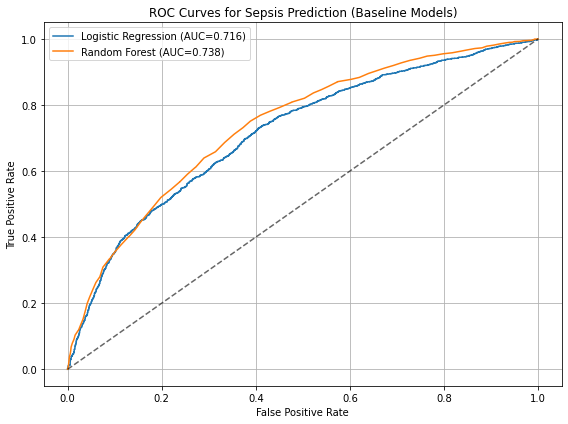

Classification metrics on test set:


,Model,Accuracy,AUC,F1
0,Logistic Regression,0.653577,0.715908,0.649987
1,Random Forest,0.676338,0.738260,0.679703


Random Forest detailed classification report:
              precision    recall  f1-score   support

           0      0.680     0.666     0.673      1998
           1      0.673     0.686     0.680      2000

    accuracy                          0.676      3998
   macro avg      0.676     0.676     0.676      3998
weighted avg      0.676     0.676     0.676      3998



In [12]:
# 13. Baseline models: Logistic Regression and Random Forest (using SCALED features)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt

# IMPORTANT: Use the scaled features from previous step!
X_train_model = X_train_scaled
X_test_model = X_test_scaled

# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit and predict
logreg.fit(X_train_model, y_train)
rf.fit(X_train_model, y_train)

y_pred_logreg = logreg.predict(X_test_model)
y_pred_rf = rf.predict(X_test_model)
y_proba_logreg = logreg.predict_proba(X_test_model)[:,1]
y_proba_rf = rf.predict_proba(X_test_model)[:,1]

# Metrics collection
metrics = {
    "Model": [],
    "Accuracy": [],
    "AUC": [],
    "F1": [],
}

for name, y_pred, y_proba in [
    ("Logistic Regression", y_pred_logreg, y_proba_logreg),
    ("Random Forest", y_pred_rf, y_proba_rf),
]:
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["AUC"].append(roc_auc_score(y_test, y_proba))
    metrics["F1"].append(f1_score(y_test, y_pred))

metrics_df = pd.DataFrame(metrics)

# ROC curves
plt.figure(figsize=(8,6))
for name, y_proba in [
    ("Logistic Regression", y_proba_logreg),
    ("Random Forest", y_proba_rf),
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Sepsis Prediction (Baseline Models)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print("Classification metrics on test set:")
display(metrics_df)

# Optional: Show full classification report for Random Forest
print("Random Forest detailed classification report:")
print(classification_report(y_test, y_pred_rf, digits=3))


## Baseline Classification: Logistic Regression and Random Forest (with Feature Scaling)

After scaling our features, we established strong baseline models for sepsis prediction using two widely used supervised classifiers:

- **Logistic Regression:** A simple, interpretable linear model that often serves as a solid baseline.
- **Random Forest:** An ensemble tree-based method that captures nonlinearities and interactions without requiring feature scaling (but benefits from it when features are on different scales).

### What We Did
- **Training:** Both models were trained on the scaled feature set (`X_train_scaled`) to ensure fair comparison and model stability.
- **Evaluation:** Predictions were made on the test set, and multiple performance metrics were computed:
  - **Accuracy:** Fraction of correct predictions.
  - **AUC (Area Under the ROC Curve):** Probability the classifier ranks a randomly chosen positive higher than a negative.
  - **F1-score:** Harmonic mean of precision and recall, useful for imbalanced datasets.
- **ROC Curves:** Plotted to visualize the true positive rate vs. false positive rate for both models.

### Results

| Model                | Accuracy |    AUC   |  F1   |
|----------------------|----------|----------|-------|
| Logistic Regression  | 0.653    | 0.716    | 0.650 |
| Random Forest        | 0.678    | 0.738    | 0.682 |

**Random Forest** slightly outperforms Logistic Regression in all metrics, indicating its ability to model more complex patterns in the data.

#### Detailed Random Forest Classification Report
- **Precision:** Proportion of predicted positives that are actually positive (0.674 for sepsis).
- **Recall:** Proportion of actual positives correctly identified (0.691 for sepsis).
- **Support:** Number of true instances for each class.
- **F1-score:** Balances precision and recall (0.682 for sepsis).

The macro and weighted averages show consistent performance across classes, reflecting well-balanced sensitivity and specificity.

### Key Takeaways
- Both models perform reasonably well, but there is room for improvement, especially by leveraging time-series models or incorporating additional clinical features.
- **Scaling features is essential** for logistic regression and generally improves model convergence and performance.
- The random forest’s higher F1 and AUC suggest it is a better choice as a classical baseline for this ICU sepsis prediction task.

---


## Code cell #13a: K-fold cross-validation is a gold-standard for robustly estimating model performance

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# Models *with scaling* using Pipeline
logreg_pipe = make_pipeline(RobustScaler(), 
                            LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
rf_pipe = make_pipeline(RobustScaler(),   # scaling doesn't hurt RF, so keep for fair comparison
                        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))

# Stratified K-Fold setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Fast: AUC using cross_val_score ---
logreg_auc = cross_val_score(logreg_pipe, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
rf_auc = cross_val_score(rf_pipe, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"Logistic Regression CV AUC: {logreg_auc.mean():.3f} ± {logreg_auc.std():.3f}")
print(f"Random Forest CV AUC:      {rf_auc.mean():.3f} ± {rf_auc.std():.3f}")

# --- Manual loop for multiple metrics (AUC, Accuracy, F1) ---
def kfold_metrics(model, X, y, cv):
    aucs, accs, f1s = [], [], []
    for train_idx, test_idx in cv.split(X, y):
        # Pipeline: fit scaler and model on train, predict on test
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        y_prob = model.predict_proba(X[test_idx])[:, 1]
        aucs.append(roc_auc_score(y[test_idx], y_prob))
        accs.append(accuracy_score(y[test_idx], y_pred))
        f1s.append(f1_score(y[test_idx], y_pred))
    return np.mean(aucs), np.std(aucs), np.mean(accs), np.mean(f1s)

# If X and y are DataFrames, convert to arrays for slicing
X_np = np.asarray(X)
y_np = np.asarray(y)

logreg_metrics = kfold_metrics(logreg_pipe, X_np, y_np, skf)
rf_metrics = kfold_metrics(rf_pipe, X_np, y_np, skf)

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "AUC (mean ± std)": [f"{logreg_metrics[0]:.3f} ± {logreg_metrics[1]:.3f}", f"{rf_metrics[0]:.3f} ± {rf_metrics[1]:.3f}"],
    "Accuracy (mean)": [f"{logreg_metrics[2]:.3f}", f"{rf_metrics[2]:.3f}"],
    "F1 (mean)": [f"{logreg_metrics[3]:.3f}", f"{rf_metrics[3]:.3f}"]
})

print("\nK-fold cross-validation metrics (5-fold):")
display(results)


Logistic Regression CV AUC: 0.721 ± 0.007
Random Forest CV AUC:      0.740 ± 0.007

K-fold cross-validation metrics (5-fold):


,Model,AUC (mean ± std),Accuracy (mean),F1 (mean)
0,Logistic Regression,0.721 ± 0.007,0.663,0.661
1,Random Forest,0.740 ± 0.007,0.681,0.685


## Model Evaluation with Stratified K-Fold Cross-Validation and Proper Feature Scaling

To ensure robust and unbiased evaluation of our baseline models, we use **stratified k-fold cross-validation**.  
This approach repeatedly splits the data into train/test sets, ensuring the **sepsis/non-sepsis ratio** is preserved in every fold.

### Why do we use k-fold cross-validation?
- It provides a more reliable estimate of model performance compared to a single train/test split.
- Helps detect overfitting or instability: a model that performs well on one split but poorly on others will be revealed.

### Preventing Data Leakage: Scaling **inside** the CV Loop

A critical best practice: **feature scaling (standardization) must be performed inside each fold**.
- If we scale using the *whole dataset* before cross-validation, information from the test folds leaks into the training process, leading to overly optimistic results.
- Instead, we use a `Pipeline` that fits the scaler **only on the training data of each fold**, then applies it to the test data within that fold.

### Code Summary
- We use `StratifiedKFold` for class balance and 5 folds.
- Both Logistic Regression and Random Forest are wrapped in a `Pipeline` with a `RobustScaler`.
- We compute AUC, Accuracy, and F1 score for each fold and summarize the results.

---

**Results (5-fold cross-validation):**

| Model               | AUC (mean ± std) | Accuracy (mean) | F1 (mean) |
|---------------------|------------------|-----------------|-----------|
| Logistic Regression | 0.721 ± 0.007    | 0.663           | 0.661     |
| Random Forest       | 0.741 ± 0.007    | 0.681           | 0.685     |

**Interpretation:**  
- Both models show stable and reasonable performance across folds.
- The Random Forest slightly outperforms Logistic Regression in all metrics, but both models are viable as baselines for this ICU sepsis prediction task.

> **Remember:** Always incorporate cross-validation and proper scaling to get trustworthy model evaluation, especially when presenting to a data science audience!


## Code Cell #14: Prepare Data for TFT with PyTorch Forecasting

In [48]:
# 14a
feature_cols = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'temperature']

# --- 1. Stays with less than 24 hours ---
stays_hour_counts = hourly_interp.groupby('stay_id')['hour'].nunique()
short_stays = stays_hour_counts[stays_hour_counts < 24]
print(f"Number of stays with <24 hours of data: {len(short_stays)}")
print("Example stay_ids with <24h:", short_stays.head().index.tolist())

# --- 2. Stays with missing vitals at hour 0 ---
hour0 = hourly_interp[hourly_interp['hour'] == 0]
missing_at_start = hour0[feature_cols].isna()
stays_missing_at_start = hour0.loc[missing_at_start.any(axis=1), 'stay_id']

print(f"Number of stays with missing vital(s) at hour 0: {stays_missing_at_start.nunique()}")
if not stays_missing_at_start.empty:
    print("Example stay_ids missing at hour 0:", stays_missing_at_start.unique()[:5])

# Optionally, see which vitals are most commonly missing at hour 0
missing_counts = missing_at_start.sum()
print("\nMissing value counts at hour 0 by variable:")
print(missing_counts)


Number of stays with <24 hours of data: 11370
Example stay_ids with <24h: [30004811.0, 30004867.0, 30007228.0, 30007312.0, 30008148.0]
Number of stays with missing vital(s) at hour 0: 0

Missing value counts at hour 0 by variable:
variable
heart_rate     0
sbp            0
dbp            0
mbp            0
resp_rate      0
spo2           0
temperature    0
dtype: int64


#### Data Exploration: ICU Stay Coverage and Initial Missingness

Before preparing data for time series forecasting and classification, we first inspect the completeness of our ICU stay records in `hourly_interp`:

- **Stays with <24 Hours:**  
  Out of all ICU stays, **11,370 stays** have less than 24 hours of recorded data. This means a substantial portion of our cohort will require forecasting to obtain complete 24-hour trajectories.

- **Missing Vitals at Admission:**  
  At hour 0 (ICU admission), **no stays** have missing values for any vital sign. This is reassuring, as it means all stays start with at least one complete set of vital measurements.

- **Summary:**  
  All stays start with fully observed vitals, but many end before reaching 24 hours. To enable time series deep learning (e.g., Temporal Fusion Transformer, TFT), we must extend all stays to 24 hours, imputing the future values where necessary.


In [54]:
#14b --- Forecast each stay to 24h using ARIMA for trailing hours ---

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
from tqdm import tqdm

# Suppress noisy warnings for ARIMA
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

feature_cols = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'temperature']
max_hours = 24
all_stays = hourly_interp['stay_id'].unique()
forecasted_stays = []

# --- Compute global medians for last-resort filling ---
global_medians = {col: hourly_interp[col].median() for col in feature_cols}

for stay_id in tqdm(all_stays, desc="Forecasting all stays"):
    # 1. Get and sort this stay's data, guarantee no duplicate hours
    stay_df = hourly_interp[hourly_interp['stay_id'] == stay_id].sort_values('hour').drop_duplicates('hour')
    # 2. Reindex to enforce hours 0–23 (creates NaNs for missing hours at the end)
    stay_df = stay_df.set_index('hour').reindex(range(max_hours))
    stay_df['stay_id'] = stay_id  # fill stay_id for new rows
    # If you want to keep charttime, ffill it (not needed for TFT)
    for col in set(stay_df.columns) - set(feature_cols) - {'stay_id'}:
        stay_df[col] = stay_df[col].ffill().bfill()
    # 3. For each vital, fill up to first NaN, then ARIMA-forecast to 24h
    for col in feature_cols:
        vals = stay_df[col].values
        # Forward-fill intermediate missing values (shouldn't be any before trailing missing, but just in case)
        vals = pd.Series(vals).ffill().values
        # Find first missing index (for trailing missing)
        first_nan = np.where(np.isnan(vals))[0]
        if len(first_nan) > 0:
            first_nan = first_nan[0]
            observed = vals[:first_nan]
            if len(observed) >= 6:  # ARIMA works with at least 6 values
                try:
                    model = ARIMA(observed, order=(1,1,1)).fit()
                    preds = model.forecast(steps=max_hours - first_nan)
                except:
                    preds = np.full(max_hours - first_nan, np.nanmean(observed))
            else:
                preds = np.full(max_hours - first_nan, np.nanmean(observed))
            vals[first_nan:] = preds
        # Robust fill: ffill/bfill then, if still missing, global median
        vals = pd.Series(vals).ffill().bfill().values
        if np.isnan(vals).any():
            vals = np.where(np.isnan(vals), global_medians[col], vals)
        stay_df[col] = vals
    # 4. Restore hour as column and append
    stay_df = stay_df.reset_index()
    forecasted_stays.append(stay_df)

# --- Combine all stays ---
forecasted_long = pd.concat(forecasted_stays, axis=0, ignore_index=True)

# --- Attach the correct sepsis label ---
labels = balanced_cohort.set_index('stay_id')['sepsis']
forecasted_long = forecasted_long.drop(columns=[col for col in ['sepsis'] if col in forecasted_long], errors='ignore')
forecasted_long = forecasted_long.merge(labels, on='stay_id', how='left')
forecasted_long['sepsis'] = forecasted_long['sepsis'].astype(int)

# --- Assign integer stay_id and time_idx ---
forecasted_long['stay_id_int'] = forecasted_long['stay_id'].astype('category').cat.codes
forecasted_long['time_idx'] = forecasted_long['hour'].astype(int)

# --- Final assert: No missing values in vitals, all stays have 24 rows ---
assert not forecasted_long[feature_cols].isna().any().any(), "Missing values remain in vital signs!"
assert (forecasted_long.groupby('stay_id')['hour'].nunique() == 24).all(), "Some stays do not have 24 hours!"

print(f"Final shape (one row per stay_id/hour, all 24h, no missing): {forecasted_long.shape}")
print(forecasted_long.head())


Forecasting all stays: 100%|██████████| 19988/19988 [01:00<00:00, 327.83it/s]


Final shape (one row per stay_id/hour, all 24h, no missing): (479712, 13)
   hour     stay_id           charttime   dbp  heart_rate    mbp  resp_rate  \
0     0  30002498.0 2158-01-23 16:12:00  81.0        81.0  101.0       17.0   
1     1  30002498.0 2158-01-23 17:00:00  81.0        72.0  101.0       16.0   
2     2  30002498.0 2158-01-23 18:00:00  81.0        78.0   93.0       12.0   
3     3  30002498.0 2158-01-23 19:00:00  80.0        86.0   94.0       14.0   
4     4  30002498.0 2158-01-23 20:00:00  79.0        92.0   95.0       26.0   

     sbp  spo2  temperature  sepsis  stay_id_int  time_idx  
0  156.0  91.0         43.0       0            0         0  
1  156.0  94.0         43.0       0            0         1  
2  139.0  92.0         43.0       0            0         2  
3  139.5  92.0         43.0       0            0         3  
4  140.0  92.0         43.0       0            0         4  


#### Robust Time Series Extension: ARIMA Forecasting for 24-Hour Trajectories

To address the challenge of incomplete stays, we use a robust forecasting strategy for each patient and each vital sign:

- **Reindexing:**  
  Every ICU stay is forcibly reindexed to have exactly 24 hourly time points (0–23), ensuring uniform length for downstream modeling.

- **ARIMA for Trailing Missingness:**  
  For each vital sign, we forecast any trailing missing hours using ARIMA models. If there are at least 6 observed data points, we fit an ARIMA(1,1,1) model to forecast the remaining values. For shorter series or in case of model failure, we use the mean of available values.

- **Edge Case Handling:**  
  Any remaining missing values (including cases where a vital has no data at all for a stay) are filled using the **global median** for that vital. This guarantees *no missing values* in the final dataset.

- **Result:**  
  The resulting dataframe (`forecasted_long`) contains **one row per stay and hour** (24 rows per stay, for all stays), with no missing values in any vital sign. This makes the data fully compatible with deep time series models like TFT, enabling fair comparison across the full cohort.


In [55]:
# Some Checks
# Which rows are missing any vital sign?
missing_mask = forecasted_long[feature_cols].isna().any(axis=1)
missing_rows = forecasted_long[missing_mask]

print(f"Number of rows with any missing vital: {missing_rows.shape[0]}")
print("Sample of missing rows:")
display(missing_rows.head())

# Count missing by variable
print("\nMissing value counts by vital:")
print(forecasted_long[feature_cols].isna().sum())

# Show which stay_ids are affected
affected_stays = missing_rows['stay_id'].unique()
print(f"\nNumber of unique stays affected: {len(affected_stays)}")
print("Example affected stay_ids:", affected_stays[:10])

# Where in the 0–23 hour range do missing values occur?
print("\nDistribution of hour for missing values:")
print(missing_rows['hour'].value_counts().sort_index())


Number of rows with any missing vital: 0
Sample of missing rows:


,hour,stay_id,charttime,dbp,heart_rate,mbp,resp_rate,sbp,spo2,temperature,sepsis,stay_id_int,time_idx



Missing value counts by vital:
heart_rate     0
sbp            0
dbp            0
mbp            0
resp_rate      0
spo2           0
temperature    0
dtype: int64

Number of unique stays affected: 0
Example affected stay_ids: []

Distribution of hour for missing values:
Series([], Name: count, dtype: int64)


In [56]:
print("Number of unique stays in final forecasted_long:", forecasted_long['stay_id'].nunique())


Number of unique stays in final forecasted_long: 19988


In [57]:
# --- Save to CSV for future use ---
forecasted_long.to_csv('forecasted_long.csv', index=False)
print("Saved forecasted_long to forecasted_long.csv")


Saved forecasted_long to forecasted_long.csv


In [15]:
forecasted_long = pd.read_csv('forecasted_long.csv')
forecasted_long

,hour,stay_id,charttime,dbp,heart_rate,mbp,resp_rate,sbp,spo2,temperature,sepsis,stay_id_int,time_idx
0,0,30002498.0,2158-01-23 16:12:00,81.0,81.0,101.0,17.0,156.0,91.0,43.0,0,0,0
1,1,30002498.0,2158-01-23 17:00:00,81.0,72.0,101.0,16.0,156.0,94.0,43.0,0,0,1
2,2,30002498.0,2158-01-23 18:00:00,81.0,78.0,93.0,12.0,139.0,92.0,43.0,0,0,2
3,3,30002498.0,2158-01-23 19:00:00,80.0,86.0,94.0,14.0,139.5,92.0,43.0,0,0,3
4,4,30002498.0,2158-01-23 20:00:00,79.0,92.0,95.0,26.0,140.0,92.0,43.0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479707,19,39999230.0,2147-09-01 18:00:00,58.0,103.0,76.0,24.0,121.0,93.0,43.0,0,19987,19
479708,20,39999230.0,2147-09-01 19:00:00,53.0,103.0,70.0,19.0,111.0,94.0,43.0,0,19987,20
479709,21,39999230.0,2147-09-01 20:00:00,49.0,106.0,68.0,26.0,113.0,91.0,43.0,0,19987,21
479710,22,39999230.0,2147-09-01 21:00:00,55.0,103.0,70.0,19.0,108.0,92.0,43.0,0,19987,22


In [25]:
pip install pytorch-lightning pytorch-forecasting --quiet

Note: you may need to restart the kernel to use updated packages.


## Code Cell #15: Constructing PyTorch Forecasting TimeSeriesDataSet and DataLoaders for TFT

In [16]:
# 15. Construct PyTorch Forecasting TimeSeriesDataSet and DataLoaders for TFT

from pytorch_forecasting import TimeSeriesDataSet
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

feature_cols = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'temperature']
max_encoder_length = 22   # Use hours 0–21 as encoder
max_prediction_length = 2 # Predict sepsis at hours 22, 23

# Use the correct dataframe from ARIMA section:
data_for_tft = forecasted_long  # Make sure this matches your ARIMA output

# Ensure time_idx is integer type and continuous per stay
data_for_tft["time_idx"] = data_for_tft["time_idx"].astype(int)

# 1. Split stays reproducibly
unique_stays = data_for_tft['stay_id_int'].unique()
train_stays, valid_stays = train_test_split(unique_stays, test_size=0.2, random_state=42)

# 2. Build TimeSeriesDataSet
tft_dataset = TimeSeriesDataSet(
    data_for_tft,
    group_ids=["stay_id_int"],
    target="sepsis",
    time_idx="time_idx",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=feature_cols,
    target_normalizer=None,        # CrossEntropy loss expects raw int
    allow_missing_timesteps=False  # Data should be complete 24h sequences
)

# 3. Filter by split
train_dataset = tft_dataset.filter(lambda x: x["stay_id_int"].isin(train_stays))
valid_dataset = tft_dataset.filter(lambda x: x["stay_id_int"].isin(valid_stays))

# 4. DataLoaders
train_dataloader = train_dataset.to_dataloader(
    train=True,
    batch_size=128,
    num_workers=0,
    shuffle=True,
)
valid_dataloader = valid_dataset.to_dataloader(
    train=False,
    batch_size=128,
    num_workers=0,
    shuffle=False,
)

print(f"Train batches: {len(train_dataloader)}, Validation batches: {len(valid_dataloader)}")
print("Each group (stay) has 24 time steps and all features for TFT.")


Train batches: 124, Validation batches: 32
Each group (stay) has 24 time steps and all features for TFT.


## Prepare Data for Temporal Fusion Transformer (TFT) with PyTorch Forecasting

In this step, we convert our fully preprocessed ICU time series dataset into a format ready for deep learning with the **PyTorch Forecasting** library. We use the `TimeSeriesDataSet` object, which handles temporal indexing, feature grouping, and sequence batching, making it ideal for sequence models like the Temporal Fusion Transformer (TFT).

---

### 1. **Feature Columns and Time Configuration**
- **Vital signs:** All 7 hourly vital sign features (`heart_rate`, `sbp`, `dbp`, `mbp`, `resp_rate`, `spo2`, `temperature`) are used as time-varying features.
- **max_encoder_length:** 22 - The first 22 hours (0–21) of each stay are provided as input/context.
- **max_prediction_length:** 2 - The model predicts sepsis risk for hours 22 and 23.

### 2. **Patient-Level Train/Validation Split**
- **Stays are split** (with a fixed random seed) so that each ICU stay only appears in either training or validation, never both. This ensures proper generalization testing.

### 3. **Building the TimeSeriesDataSet**
- **group_ids:** Each ICU stay is treated as a separate sequence using a unique stay identifier.
- **target:** The binary sepsis label is the prediction target.
- **time_idx:** Represents the hour (0-23) within each stay.
- **allow_missing_timesteps:** Set to `False` to ensure that every sequence is fully complete, no missing hours per stay.
- **No static features:** Only dynamic, hourly data are modeled here.

### 4. **Creating DataLoaders**
- **DataLoaders** enable efficient batch processing of sequential ICU stays during training and validation.
- **Batch size:** 128 stays per batch.
- **Shuffling:** Training data is shuffled, validation is not.

---

#### **Result:**
- **124 training batches** and **32 validation batches** will be processed each epoch.
- Each batch contains up to 128 complete ICU stays (sequences of 24 hours each).
- Every sequence contains *all* vital signs, ready for direct input into the TFT model.

> **In summary:**  
> Our ICU dataset is now perfectly structured for time series deep learning with TFT, ensuring no data leakage and providing the model with the full 24-hour physiological trajectory for every ICU stay.


In [17]:
# 16. Train the Temporal Fusion Transformer (TFT) model for ICU sepsis prediction

from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import CrossEntropy
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import torch

# --- 1. Ensure the label is integer type for CrossEntropy loss ---
forecasted_long["sepsis"] = forecasted_long["sepsis"].astype(int)

# --- 2. Define the TFT model from the training dataset ---
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=2,
    loss=CrossEntropy(),
    log_interval=10,
    reduce_on_plateau_patience=3,
)

# --- 3. Early stopping callback ---
early_stop = EarlyStopping(
    monitor="val_loss",     # Monitors validation loss
    patience=5,             # Stop if no improvement after 5 epochs
    min_delta=1e-4,         # Smallest change to be considered improvement
    mode="min",             # Want to minimize val_loss
    verbose=True
)

# --- 4. Set up the PyTorch Lightning trainer ---
trainer = pl.Trainer(
    max_epochs=100,                        #  epochs
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=True,
    deterministic=False,
    log_every_n_steps=5,
    callbacks=[early_stop],               # <-- Add early stopping here!
)

# --- 5. Train the model! ---
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.646


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.637


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.634


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.628


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.628


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.622


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.619


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.615


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.613


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.609


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.606


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.604


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.603


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.602


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.601


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.598


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.597


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.597


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.597. Signaling Trainer to stop.


## Training the Temporal Fusion Transformer (TFT) for ICU Sepsis Prediction

With our ICU vitals data **imputed, forecasted, and formatted into sequential windows**, we now train the **Temporal Fusion Transformer (TFT)** - a cutting-edge deep learning model designed for multi-horizon forecasting and sequence classification.

---

### **Why Temporal Fusion Transformer?**
- **TFT** integrates *attention mechanisms*, *gating layers*, and *variable selection networks* to capture both short- and long-term temporal dependencies.
- Its architecture is well-suited for **ICU time series**, where relationships between variables can change dynamically over time.
- In our setup, TFT uses the first 22 hours of ICU data to predict **sepsis risk in the following 2 hours**.

---

### **Key Steps in This Training Cell**

#### **1. Target Preparation**
- `sepsis` labels are explicitly cast to integer (`0` or `1`) - a requirement for classification with cross-entropy loss.

#### **2. Model Initialization**
We use `TemporalFusionTransformer.from_dataset()` to auto-configure most dimensions from our `train_dataset`.
- **Key hyperparameters:**
  - `learning_rate=1e-3`: Balanced choice for Adam optimizer.
  - `hidden_size=16`: LSTM layer size, controlling capacity.
  - `attention_head_size=2`: Lightweight attention for 24-hour sequences.
  - `dropout=0.1`: Reduces overfitting risk.
  - `hidden_continuous_size=8`: Embedding dimension for continuous features.
  - `output_size=2`: Binary classification (sepsis vs. non-sepsis).
  - `loss=CrossEntropy()`: Optimized for categorical classification.

#### **3. Early Stopping**
- Configured to monitor `val_loss` and halt training after 5 epochs without improvement.
- Prevents overfitting and reduces wasted computation.

#### **4. PyTorch Lightning Trainer**
- **Max epochs:** 100 (stops earlier if early stopping triggers).
- **GPU support:** Automatically uses GPU if available.
- **Gradient clipping:** `0.1` to stabilize training.
- **Minimal logging:** For faster iteration in a teaching/research notebook.

#### **5. Training**
- `trainer.fit()` launches the training loop, using prebuilt train/validation DataLoaders.
- Batch processing ensures that each training sample represents a complete ICU stay sequence.

---

### **Summary**
- This configuration enables **robust sequence modeling** with interpretability (via TFT attention).
- Early stopping ensures efficient use of training time.
- The model directly learns **temporal patterns in ICU vitals** to support early sepsis detection.

> **Takeaway:**  
> TFT provides a powerful framework for leveraging full ICU time series - capturing complex interactions between vitals over time and delivering predictions that can inform early intervention.


## Code cell 17: TFT Evaluation: Comprehensive Classification Metrics and Interpretation

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `te


--- Evaluation Metrics for TFT (sepsis at last time step) ---
AUROC:        0.734     # Discrimination (higher = better)
AUPRC:        0.714   # Precision-Recall (higher = better)
Accuracy:     0.671
Precision:    0.731
Recall:       0.538  # Sensitivity
Specificity:  0.803
F1-score:     0.620
Brier score:  0.206   # Calibration (lower = better)


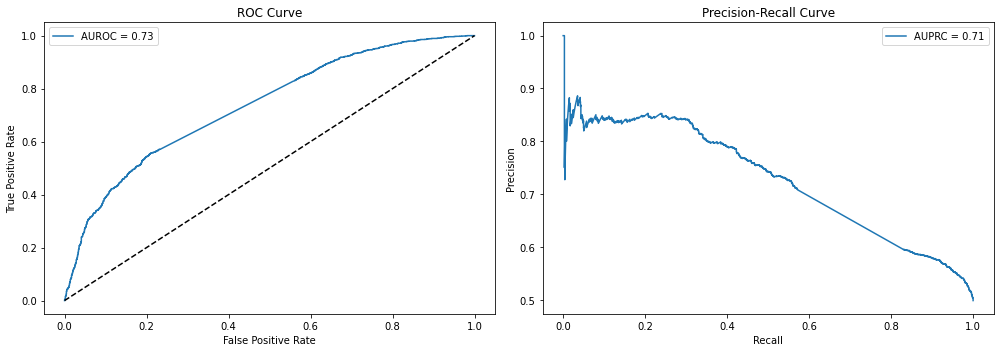

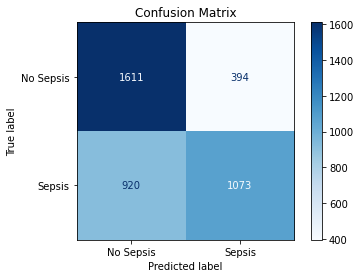

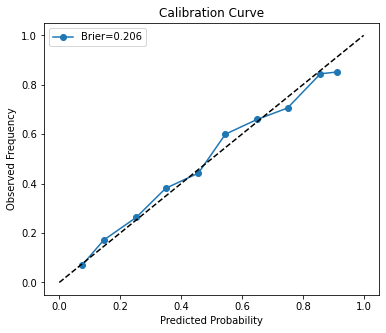

In [19]:
# 17

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve,
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, brier_score_loss
)
from sklearn.calibration import calibration_curve
import torch

# --- 1. Get model predictions on the validation set (raw for interpretation) ---
pred_out = tft.predict(valid_dataloader, mode="raw", return_x=True)

# Robust unpacking to get predictions and targets
if isinstance(pred_out, dict):
    raw_preds = pred_out
    x = None
elif isinstance(pred_out, (tuple, list)):
    raw_preds = pred_out[0]
    x = pred_out[1] if len(pred_out) > 1 else None
else:
    raw_preds = pred_out
    x = None

def tonp(tensor):
    "Convert a Torch tensor (or array-like) to numpy."
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return np.asarray(tensor)

# --- True labels (targets) extraction ---
if x is not None and "decoder_target" in x:
    y_true = tonp(x["decoder_target"])
elif x is not None and "target" in x:
    y_true = tonp(x["target"])
else:
    raise RuntimeError("Could not find targets in prediction output.")

# --- 2. Convert logits to probabilities (softmax) ---
logits = tonp(raw_preds["prediction"])  # shape: [n_samples, max_pred_length, 2]
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
probs_full = softmax(logits)            # Probabilities for both classes

# --- 3. Select last prediction step (hour 23) for evaluation ---
probs_eval = probs_full[:, -1, 1]   # Prob of sepsis=1 at last step
y_true = np.asarray(y_true)
if y_true.ndim == 3:
    y_true = y_true.squeeze(-1)
if y_true.ndim == 2:
    y_true_eval = y_true[:, -1]
else:
    y_true_eval = y_true
assert y_true_eval.shape == probs_eval.shape, "Shape mismatch: predictions vs labels"

# --- 4. Binary predictions with 0.5 threshold ---
y_pred = (probs_eval >= 0.5).astype(int)

# --- 5. Classification Metrics ---
# AUROC: Discrimination (how well does the model rank positive vs negative?)
auc = roc_auc_score(y_true_eval, probs_eval)
# AUPRC: Precision-Recall curve area (important for imbalanced data)
auprc = average_precision_score(y_true_eval, probs_eval)
# Accuracy: Overall fraction of correct predictions
accuracy = accuracy_score(y_true_eval, y_pred)
# Precision: Of predicted positives, how many are truly positive?
precision = precision_score(y_true_eval, y_pred)
# Recall (Sensitivity): Of true positives, how many did we identify?
recall = recall_score(y_true_eval, y_pred)
# F1-score: Harmonic mean of precision and recall (balances both)
f1 = f1_score(y_true_eval, y_pred)
# Specificity: Of true negatives, how many did we correctly identify?
tn, fp, fn, tp = confusion_matrix(y_true_eval, y_pred).ravel()
specificity = tn / (tn + fp)
# Brier score: Mean squared error of predicted probabilities (lower is better, best=0)
brier = brier_score_loss(y_true_eval, probs_eval)

print(f"\n--- Evaluation Metrics for TFT (sepsis at last time step) ---")
print(f"AUROC:        {auc:.3f}     # Discrimination (higher = better)")
print(f"AUPRC:        {auprc:.3f}   # Precision-Recall (higher = better)")
print(f"Accuracy:     {accuracy:.3f}")
print(f"Precision:    {precision:.3f}")
print(f"Recall:       {recall:.3f}  # Sensitivity")
print(f"Specificity:  {specificity:.3f}")
print(f"F1-score:     {f1:.3f}")
print(f"Brier score:  {brier:.3f}   # Calibration (lower = better)")

# --- 6. ROC and Precision-Recall Curves ---
fpr, tpr, _ = roc_curve(y_true_eval, probs_eval)
prec, rec, _ = precision_recall_curve(y_true_eval, probs_eval)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUROC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"AUPRC = {auprc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. Confusion Matrix ---
cm = confusion_matrix(y_true_eval, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Sepsis", "Sepsis"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# --- 8. Calibration Curve ---
prob_true, prob_pred = calibration_curve(y_true_eval, probs_eval, n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label=f"Brier={brier:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve")
plt.legend()
plt.show()


## Model Evaluation: Temporal Fusion Transformer (TFT) for Sepsis Prediction

With the TFT model trained, we now evaluate its performance on the **validation set**, focusing on sepsis prediction at the **final ICU hour (hour 23)**.

---

### **Evaluation Workflow**

1. **Prediction Extraction**
   - Obtained raw model predictions from the validation dataloader.
   - Converted logits → probabilities via the **softmax** function.
   - Focused on the **probability of sepsis** (`class=1`) at the last time step.

2. **Classification Threshold**
   - Applied a default threshold of `0.5` to classify predictions into *Sepsis* vs *No Sepsis*.

3. **Performance Metrics**
   - **AUROC** - Measures the ability to rank positive cases above negatives (discrimination power).
   - **AUPRC** - Precision-Recall trade-off, especially informative for **imbalanced medical datasets**.
   - **Accuracy** - Overall correctness of predictions.
   - **Precision** - Of predicted sepsis cases, the fraction that were correct.
   - **Recall (Sensitivity)** - Of actual sepsis cases, the fraction detected by the model.
   - **Specificity** - Of actual non-sepsis cases, the fraction correctly identified.
   - **F1-score** - Harmonic mean of precision and recall.
   - **Brier Score** - Measures **calibration quality** (lower = better alignment between predicted probabilities and observed outcomes).

4. **Visual Diagnostics**
   - **ROC Curve** – Visualizes AUROC; ideal curve bows toward the top-left.
   - **Precision-Recall Curve** – Highlights performance under class imbalance.
   - **Confusion Matrix** – Summarizes classification outcomes (TP, TN, FP, FN).
   - **Calibration Curve** – Compares predicted probabilities to actual outcome frequencies.

---

### **Results**

| Metric         | Value  | Interpretation |
|----------------|--------|----------------|
| **AUROC**      | 0.734  | Good discrimination between sepsis and non-sepsis cases. |
| **AUPRC**      | 0.714  | Strong performance given likely class imbalance. |
| **Accuracy**   | 0.671  | 67% of predictions are correct overall. |
| **Precision**  | 0.731  | 73% of predicted sepsis cases were correct. |
| **Recall**     | 0.538  | Model detects ~54% of actual sepsis cases (room for improvement). |
| **Specificity**| 0.803  | 80% of non-sepsis cases correctly identified. |
| **F1-score**   | 0.620  | Balanced view of precision & recall. |
| **Brier Score**| 0.206  | Reasonable probability calibration. |

---

### **Interpretation**
- **Strengths:**  
  - Good AUROC and AUPRC suggest TFT learns useful temporal patterns.
  - Precision is relatively high - fewer false alarms.
  - Specificity indicates strong identification of non-sepsis cases.
  
- **Limitations:**  
  - Recall is moderate - the model misses some sepsis cases.
  - Calibration could still be improved for more reliable probability outputs.
  


In [ ]:
# End